## Import main packages

In [90]:
import pandas as pd                         # pip install pandas
import numpy as np                          # pip install numpy
import matplotlib.pyplot as plt             # pip install matplotlib
import seaborn                              # pip install seaborn           or kung ayaw = pip install seaborn --user
import time                                 # pip install -U scikit-learn
                                            # pip install tqdm
                                            # pip install logitboost
                                            # pip install bayesian-optimization
# !!! BEFURE RUNNING, PLEASE CREATE A FOLDER NAMED "results" IN THE SAME LOCATION/DIRECTORY AS THIS FILE (sibling)

## Adjustments (knobs/parameters) - added for more flexibility

In [100]:
# [0:"kNN", 1:"DT", 2:"AdaBoost", 3:"GNB", 4:"LR", 5:"SVM.SVC", 6:"LogitBoost", 7:"LDA", 8:"LDA_a", 9:"LDA_b", 10:"LDA_c"]
mls_to_test = [8, 9, 10]

# training iteration multiplier (author used 100, we should set it to 100 during our final run just in case)
tim = 1                 # author used 100

# number of splits for stratified shuffle split
ssv = 30                # author used 30

# test size to used as opposed to training size (%)
test_size = 0.25        # author used .025

# seed for training (author used "0" or zero), 'None' randomizes the seed value
seed_value = 0       # author used 0 

## Import Specific Modules

In [93]:
# preprocessing
from sklearn.preprocessing import normalize

# classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from logitboost import LogitBoost

from tqdm import tqdm
# model selection
from sklearn.model_selection import StratifiedShuffleSplit

# model evaluation
from sklearn.metrics import confusion_matrix, auc

# NEW STUFF
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

## Define settings for printing, plotting, etc.

In [94]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
%matplotlib inline

## Read input data from file
Data contains 3 columns: 'date', 'rain1'(1-day cumulative rainfall), and 'ls' (boolean to indicate if date is a landslide or non-landslide event). Rainfall data, from 2014 to 2018 is from PAGASA Baguio synoptic station, whereas landslide or non-landslide event is determined from the maintenance records of the DPWH.

In [95]:
# read from csv file, get 'date', 'rain', and 'landslide' columns
data_dir = "DATAhumidity.csv"
rainls = pd.read_csv(data_dir, usecols=list(range(0, 12)))

# format date column
rainls["date"] = pd.to_datetime(rainls["date"])

# show first five rows of dataframe - check if it processed/loaded just fine
print(rainls.head(10))

# show dimensions of the dataframe (rows, columns) - check if it processed/loaded just fine
rainls.shape

        date  rain1  totmaxh  meanmaxh  totminh  meanminh   aveh  highh  \
0 2015-01-01  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
1 2015-01-02  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
2 2015-01-03  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
3 2015-01-04  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
4 2015-01-05  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
5 2015-01-06  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
6 2015-01-07  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
7 2015-01-08  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
8 2015-01-09  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
9 2015-01-10  0.000  675.500    21.790  376.600    12.148 16.969 24.600   

    lowh  meanh  relhumh  den  
0 10.400 17.500       84    0  
1 10.400 17.500       84    0  
2 10.400 17.500       84    0  
3 10.400 17.500       84    0  
4 10.400 17.50

(1461, 12)

## Create features

With the hypothesis that the landslide occurrences are determined by certain rainfall characteristics, we create features (columns) from the rainfall time series in our input data.  We explore combinations of cumulative and offset functions to generate the various rainfall characteristics.

In [88]:
# FINAL FEATURE GENERATION
shift = list(range(0, 175))     #(25 weeks) #(Carvajal, T.M., Viacrusis, K.M., Hernandez, L.F.T. et al. Machine learning methods reveal the temporal pattern of dengue incidence using meteorological factors in metropolitan Manila, Philippines. BMC Infect Dis 18, 183 (2018). https://doi.org/10.1186/s12879-018-3066-0)
shiftrain = pd.DataFrame(index=rainls.index)
for i in shift:
    shiftrain[f"shift_{str(i)}"] = rainls["rain1"].shift(-i)
    shiftrain[f"shiftmmaxh_{str(i)}"] = rainls["meanmaxh"].shift(-i)
    shiftrain[f"shiftmminh_{str(i)}"] = rainls["meanminh"].shift(-i)
    shiftrain[f"shiftmeanh_{str(i)}"] = rainls["meanh"].shift(-i)
    shiftrain[f"shiftrh_{str(i)}"] = rainls["relhumh"].shift(-i)
# adding lables to samples (rows)
shiftrain["den"] = rainls.den
# removing NaNs as result of cumulative and lag functions
shiftrain = shiftrain.dropna(axis=0, how="any")
COrain = shiftrain

# check if it processed/loaded just fine
print(COrain.head(10))  

C:\Users\MIS\AppData\Local\Temp\ipykernel_1992\2662877724.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shiftrain[f"shift_{str(i)}"] = rainls["rain1"].shift(-i)
C:\Users\MIS\AppData\Local\Temp\ipykernel_1992\2662877724.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shiftrain[f"shiftmmaxh_{str(i)}"] = rainls["meanmaxh"].shift(-i)
C:\Users\MIS\AppData\Local\Temp\ipykernel_1992\2662877724.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

   shift_0  shiftmmaxh_0  shiftmminh_0  shiftmeanh_0  shiftrh_0  shift_1  \
0    0.000        21.790        12.148        17.500         84    0.000   
1    0.000        21.790        12.148        17.500         84    0.000   
2    0.000        21.790        12.148        17.500         84    0.000   
3    0.000        21.790        12.148        17.500         84    0.000   
4    0.000        21.790        12.148        17.500         84    0.000   
5    0.000        21.790        12.148        17.500         84    0.000   
6    0.000        21.790        12.148        17.500         84    0.000   
7    0.000        21.790        12.148        17.500         84    0.000   
8    0.000        21.790        12.148        17.500         84    0.000   
9    0.000        21.790        12.148        17.500         84    0.000   

   shiftmmaxh_1  shiftmminh_1  shiftmeanh_1  shiftrh_1  ...  shiftmmaxh_173  \
0        21.790        12.148        17.500     84.000  ...          24.600   
1    

C:\Users\MIS\AppData\Local\Temp\ipykernel_1992\2662877724.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shiftrain[f"shiftrh_{str(i)}"] = rainls["relhumh"].shift(-i)
C:\Users\MIS\AppData\Local\Temp\ipykernel_1992\2662877724.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shiftrain[f"shift_{str(i)}"] = rainls["rain1"].shift(-i)
C:\Users\MIS\AppData\Local\Temp\ipykernel_1992\2662877724.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

## Save shifted data(COrain) to CSV - just in case for whatever reason

In [89]:
try:
    COrain.to_csv("results/shifted_data.csv", index="false")            # there's a bug if you use a trailing slash '/' before the folder/directory
except OSError as e:
    print(e)

## NEW STUFF S1 - (core of our study)

In [22]:


# Step 1 - Initialize distribution parameters
# max_components = min(len(COrain.index), len(COrain.columns))
# max_components = min(Xtrain_norm.shape[1], len(np.unique(ytrain)) - 1)
max_components = 2

# Grid Search Parameters
param_grid = {
    "solver": ["svd", "lsqr", "eigen"],         # ["svd"], "lsqr", "eigen"
    "shrinkage": [None, "auto", 0.1, 0.5, 0.9],                        # float                 ### Should not be used if covariance_estimator is used
    "priors": [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]], # array-like of shape (n_classes,), [None] ### # !!! This could probably be automated using some binary search tree clone fufu algorithm???
    "n_components": [None, 1, 2, 3],            # int, [None]
    # "store_covariance": False,                # numpy array
    "tol": [1e-4, 1e-3, 1e-2],              # float, [1.0e-4]           ### ONLY WORKS WITH 'svd' solver
    # "covariance_estimator": None              # [None]                    ### ONLT WORKS WITH 'lsqr' & 'eigen' solvers. Should be None if shrinkage is used
}

# Random Search Parameters
param_distributions = {
    # "estimator": ???                          # estimator object
    "C": [1, 10, 20], 
    "kernel": ["rbf", "linear"],
    
    'solver': ['svd', 'lsqr', 'eigen'],
    'n_components': [None] + list(range(1, max_components )),
    'tol': np.logspace(0, 100, 1),
    'priors': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],       # !!! This could probably be automated using some binary search tree clone fufu algorithm
}

## NEW STUFF S2a - Grid Search

In [137]:

sss = StratifiedShuffleSplit(n_splits=ssv, test_size=test_size, random_state=seed_value)
grid_search = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=param_grid, return_train_score=True, cv=sss) # scoring="accuracy", 
start_time = time.time()
try:
    # from sklearn.model_selection import train_test_split
    X = COrain.drop(columns=["den"])
    y = COrain["den"]
    # Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=42)
    # ytrain, ytest = COrain["den"].iloc[train_index], COrain["den"].iloc[test_index]
    # Xtrain, Xtest = COrain[COrain.columns[:-1]].iloc[train_index], COrain[COrain.columns[:-1]].iloc[test_index]
    # Xtrain_norm, Xnorm = normalize(Xtrain, axis=0, return_norm=True)
    grid_search.fit(X, y)
except NameError as e:
    display("e", e)
except TypeError as e:
    display(e)
end_time = time.time()

time_spent = end_time - start_time
gs_optimal_params = grid_search.best_params_
print(gs_optimal_params)         # {'n_components': None, 'priors': None, 'solver': 'svd', 'tol': 1.0}
print(time_spent)

KeyboardInterrupt: 

In [29]:
gs_optimal_params = grid_search.best_params_
print(type(gs_optimal_params), gs_optimal_params)         # {'n_components': None, 'priors': None, 'solver': 'svd', 'tol': 1.0}
print(grid_search.cv_results_)

<class 'dict'> {'n_components': None, 'priors': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 0.0001}
{'mean_fit_time': array([0.62996267, 0.62953678, 0.62913437, ..., 0.03416204, 0.03724922,
       0.0346058 ]), 'std_fit_time': array([0.01905251, 0.01002523, 0.01789557, ..., 0.00705288, 0.0196477 ,
       0.00742088]), 'mean_score_time': array([0.01816085, 0.01673619, 0.01790675, ..., 0.        , 0.        ,
       0.        ]), 'std_score_time': array([0.01967528, 0.01887136, 0.01871725, ..., 0.        , 0.        ,
       0.        ]), 'param_n_components': masked_array(data=[None, None, None, ..., 3, 3, 3],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_priors': masked_array(data=[None, None, None, ..., list([0.5, 0.5]),
                   list([0.5, 0.5]), list([0.5, 0.5])],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_sh

<span style="color:orange; font-size:48px; font-weight:700">NEW STUFF S2b - Randomized Search</span>

In [144]:
randomized_search = RandomizedSearchCV(LinearDiscriminantAnalysis(), n_iter=50, param_distributions=param_grid, scoring="accuracy", cv=sss, return_train_score=True)
# rs = RandomizedSearchCV(SVC(gamma="auto"), {"C": [1, 10, 20], "kernel": ["rbf", "linear"]}, cv=5, return_train_score=False, n_iter=2)
start_time = time.time()

try:
    # from sklearn.model_selection import train_test_split
    X = COrain.drop(columns=["den"])
    y = COrain["den"]
    randomized_search.fit(X, y)
except NameError as e:
    display("e", e)
except TypeError as e:
    display(e)
except ValueError as e:
    display(e)
end_time = time.time()

time_spent = end_time - start_time
rs_optimal_params = randomized_search.best_params_
print(rs_optimal_params)         # {'n_components': None, 'priors': None, 'solver': 'svd', 'tol': 1.0}
print(time_spent)

In [61]:
print("aaa", randomized_search.best_estimator_)
print("bbb", randomized_search.best_score_)
print("ccc", randomized_search.best_params_)
# rs_optimal_params = randomized_search.best_params_
# print(type(gs_optimal_params), gs_optimal_params)         # {'n_components': None, 'priors': None, 'solver': 'svd', 'tol': 1.0}
# print(grid_search.cv_results_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

## NEW STUFF S2c - Bayesian Optimization

In [ ]:
def objective_function(solver, n_components, tol, prior_0):
    # Map continuous variable 'solver' to its categorical value
    solvers = ["svd", "lsqr", "eigen"]
    solver = solvers[int(solver)]
    
    # Ensure n_components is an integer
    n_components = int(n_components)
    
    # Calculate prior for Class 1
    prior_1 = 1 - prior_0
    priors = [prior_0, prior_1]
    
    # Train LDA and get cross-validated accuracy
    clf = LinearDiscriminantAnalysis(solver=solver, n_components=n_components, tol=tol, priors=priors)
    accuracy = np.mean(cross_val_score(clf, Xtrain_norm, ytrain, cv=5, scoring="accuracy"))
    
    return accuracy

# Bounds: solver index, n_components, tol, prior for class 0
pbounds = {
    "solver": (0, 2),
    "n_components": (1, max_components),
    "tol": (1e-6, 1e-3),
    "prior_0": (0.1, 0.5)
}

bayesian_optimization = BayesianOptimization(f=objective_function, pbounds=pbounds)
start_time = time.time()
try:
    bayesian_optimization.maximize(init_points=5, n_iter=25)
except ValueError as e:
    print("err", e)
end_time = time.time()

time_spent = end_time - start_time
print(bayesian_optimization.max["params"])
print(time_spent)

## Define classifiers, and corresponding parameters

In [139]:
classifierNames = pd.DataFrame(["kNN", "DT", "AdaBoost","GNB","LR", "SVM.SVC","LogitBoost", "LDA", "LDA_gs", "LDA_rs", "LDA_bo"])

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    make_pipeline(StandardScaler(), SVC(gamma='auto')),
    LogitBoost(n_estimators=200, random_state=0),
    LinearDiscriminantAnalysis(),  # rv.kris - this is the default of the author
    LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto', solver='lsqr', tol=0.0001),  # lester's sample a (grid search)           # {'n_components': None, 'priors': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 0.0001}
    LinearDiscriminantAnalysis(tol=0.0001, solver='lsqr', shrinkage=0.5, priors=None, n_components=1),  # rv.kris - this is the default of the author
    # tol=0.001, solver='lsqr', shrinkage=0.1, priors=[0.5, 0.5], n_components=None
    #  tol=0.0001, solver='eigen', shrinkage='auto', priors=None, n_components=None
    # 1 tol=0.01, 'solver='eigen', 'shrinkage=0.9, 'priors=[0.1, 0.9], 'n_components=1
    # 10 iter: tol=0.0001, solver='svd', shrinkage=None, priors=[0.3, 0.7], n_components=1
    # 15 iter_a: tol=0.0001, solver='eigen', shrinkage='auto', priors=None, n_components=1        # got the max/optimized w/ this
    # 15 iter_b: tol=0.0001, solver='eigen', shrinkage=0.9, priors=[0.4, 0.6], n_components=None
    # 15 iter_c: tol=0.01, solver='eigen', shrinkage='auto', priors=[0.4, 0.6], n_components=None
    # 15 iter_d: tol=0.0001, solver='lsqr', shrinkage=0.5, priors=None, n_components=1
    # 20 iter: tol=0.001, solver='eigen', shrinkage='auto', priors=None, n_components=None
    
    LinearDiscriminantAnalysis(solver='eigen', priors=[0.20541057830628257, 1 - 0.20541057830628257], n_components=1, tol=0.000769463195252916),  # lester's sample c (bayesian optimization)
]

## Splitting, training, testing, evaluating

# MEAN MAX MINIMUM TEMPERATURE RELATIVE HUMIDITY

In [140]:
my_list = list(range(tim))        # rv.kris - this increases the number of iterations, the author set this to 100, but this also multiplies the training time by the same amount

# define split function
n_splits = ssv
random_state = seed_value
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

# create dataframes for evaluation results
TPRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
TNRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
FPRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
ERRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
aROCs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])

# loop through all splits
with tqdm(total=len(my_list)) as pbar:
    for x in my_list:
        for s, (train_index, test_index) in zip(TPRs.index, sss.split(COrain.iloc[:, :-1], COrain.iloc[:, -1])):
            # define training and testing sets using results of the splitting function
            ytrain, ytest = COrain["den"].iloc[train_index], COrain["den"].iloc[test_index]
            Xtrain, Xtest = COrain[COrain.columns[:-1]].iloc[train_index], COrain[COrain.columns[:-1]].iloc[test_index]
            
            # normalize training set features (column-wise)
            Xtrain_norm, Xnorm = normalize(Xtrain, axis=0, return_norm=True)
            # normalize testing set features (column-wise)
            Xtest_norm = Xtest/Xnorm
            # loop through algorithms
            for c in range(len(classifierNames)):
                if c not in mls_to_test:continue      # skip some algorithms # rv.kris
                
                # define current classifier
                clf = classifiers[c]
                # train the classifier using the training set
                # try:
                clf.fit(Xtrain_norm, ytrain)
                # except InvalidParameterError as e:
                #     print(e)
                # predict values using the trained classifier and the test set
                Xtest_norm = np.array(Xtest_norm)         # rv.kris - local machines require the array form
                y_pred = clf.predict(Xtest_norm)
                
                # Evaluate the test
                # Define true values
                y_true = ytest
                # Produce confusion matrix from true and predicted values
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                # Compute true positive and false positive rates and assign to dataframe
                tpr = np.round((tp / (tp+fn*1.)), 4)
                fpr = np.round((fp / (fp+tn*1.)), 4)
                tnr = np.round((tn / (tn+fp*1.)), 4)
                err = np.round((fp+fn / (tn+fp+tp+fn*1.)), 4)
                aROC = auc([0, fpr, 1], [0, tpr, 1])
                # Assign results to dataframes
                TPRs.loc[s, classifierNames.values[c][0]] = tpr
                TNRs.loc[s, classifierNames.values[c][0]] = tnr
                FPRs.loc[s, classifierNames.values[c][0]] = fpr
                ERRs.loc[s, classifierNames.values[c][0]] = err
                aROCs.loc[s, classifierNames.values[c][0]] = aROC
            pbar.update(1)

# Remove NA columns (skipped algorithms)
FPRs = FPRs.dropna(axis=1, how="all")
TPRs = TPRs.dropna(axis=1, how="all")
TNRs = TNRs.dropna(axis=1, how="all")
ERRs = ERRs.dropna(axis=1, how="all")
aROCs = aROCs.dropna(axis=1, how="all")

30it [00:42,  1.42s/it]                      


In [ ]:
## KRIS' PERSONAL DEBUGGING BULLSHITERY

from sklearn import datasets
from sklearn.linear_model import LinearRegression
iris = datasets.load_iris()

X = COrain.drop(columns=["den"])
y = COrain["den"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("haha")
print(pred)


# sv = GridSearchCV(SVC(gamma="auto"), { "C": [1,10,20], "kernel": ["rbf", "linear"]}, scoring="accuracy", return_train_score=True, cv=5)
# sv.fit(COrain.values, COrain["den"].tolist())
# display("ppp", pd.DataFrame(sv.cv_results_)[['param_C','param_kernel','mean_test_score']])

# gs = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=param_grid, scoring="accuracy", return_train_score=True, cv=5)
# gs.fit(COrain.values, COrain["den"].tolist())
# display("ppp", pd.DataFrame(gs.cv_results_)[['param_C','param_kernel','mean_test_score']])

try:
    # rs = RandomizedSearchCV(LinearDiscriminantAnalysis(), param_distributions=param_grid, cv=5, return_train_score=False, n_iter=2)
    # rs.fit(iris.data, iris.target)
    # display("qqq", pd.DataFrame(rs.cv_results_)[['param_C','param_kernel','mean_test_score']])
    
    # gs = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=param_grid, scoring="accuracy", return_train_score=True, cv=5)
    # gs.fit(COrain.values, COrain["den"].tolist())
    # display("qqq", pd.DataFrame(gs.cv_results_)[['param_C','param_kernel','mean_test_score']])
    
    
    TTSs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
    # display("a", TTSs.describe())
    # display("b", COrain["den"].describe)
    
    # jjj = zip(TTSs.index, sss.split(COrain, COrain["den"]))
    # for s, (train_index, test_index) in jjj:
    #     train = COrain.iloc[train_index]
    #     test = COrain.iloc[test_index]
        
    # display("aaa \n", train)
    # display("bbb \n", test)
    # kkk = sss.split(COrain, COrain["den"])
    # display("1)", type(TTSs), TTSs)                         # pandas.core.frame.DataFrame
    # display("2)", type(TTSs.index), TTSs.index)             # pandas.core.indexes.range.RangeIndex
    # display("3)", type(jjj), jjj)                           # zip
    # display("4)", type(kkk), kkk)                           # generator
    # X = COrain.drop(["den"], axis=1)
    
    # for s, (train_index, test_index) in zip(TTSs.index, kkk):
    #     print("alpha", s, train_index)
    
    # display("omega", type(X), x)
    # X = iris.drop
    # X_train, X_test, y_train, y_test = train_test_split()
except ValueError as e:
    display("v", e)
except TypeError as e:
    display("t", e)

# rs.fit(COrain.values, COrain["den"].tolist())

# try:
# cross_val_score(classifiers[7], COrain.values, COrain["den"].tolist(), cv=5)
# except ValueError as e:
#     print(e)

# display("222", type(Xtrain_norm.shape), Xtrain_norm.shape)

# display("aaa", type(iris), iris)
# display("bbb", type(iris.data), iris.data)
# display("ccc", type(iris.target), iris.target)

# display("xxx", type(COrain), COrain)
# display("yyy", type(COrain.values), COrain.values)
# display("zzz", type(COrain["den"].tolist()), COrain["den"].tolist())



## Results

100%|██████████| 1/1 [00:00<00:00, 498.49it/s]


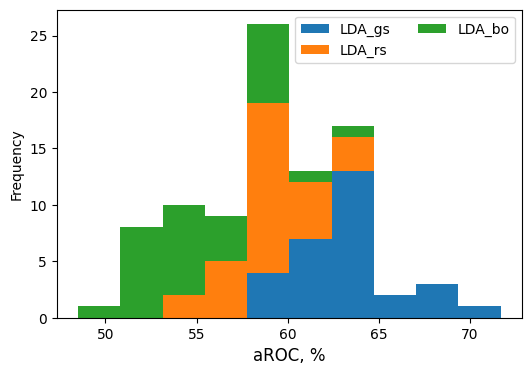

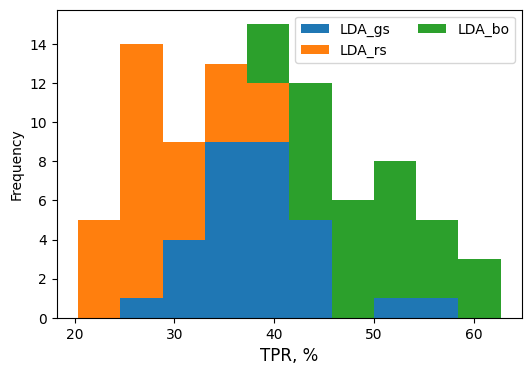

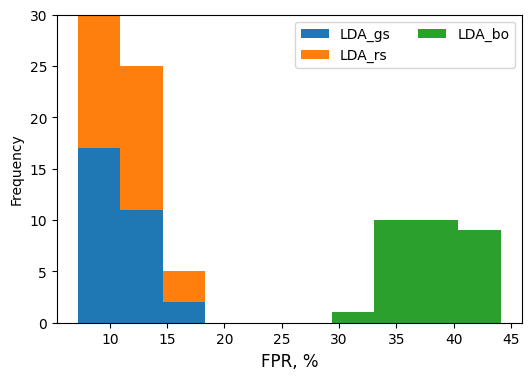

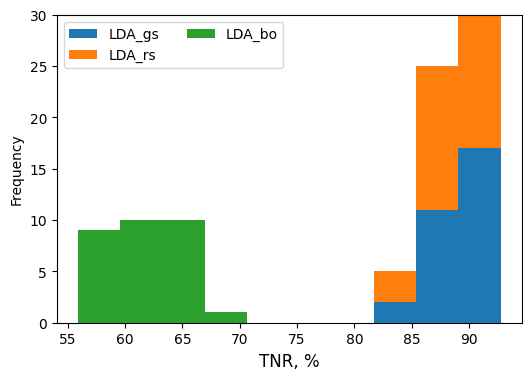

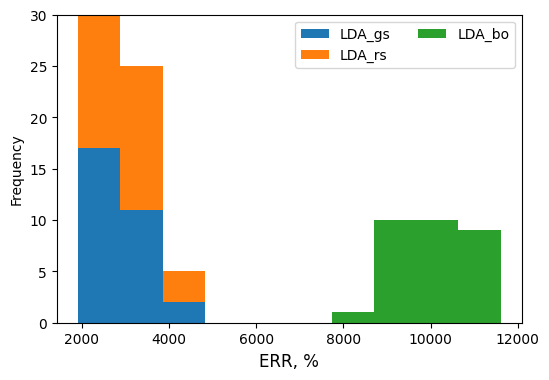

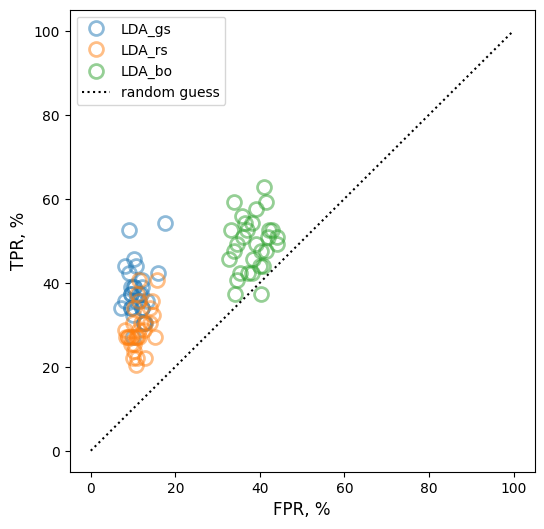

In [141]:
# my_list = list(range(100))
# convert results to percent (0-100)
_FPRs = FPRs * 100
_TPRs = TPRs * 100
_TNRs = TNRs * 100
_ERRs = ERRs * 100
_aROCs = aROCs * 100

# rv.kris - fix for data type error (was object, needs to be float)
for i in range(len(classifierNames)):
    if i not in mls_to_test:continue
    _aROCs[classifierNames[0][i]] = _aROCs[classifierNames[0][i]].astype(float)         # rv.kris
    _TPRs[classifierNames[0][i]] = _TPRs[classifierNames[0][i]].astype(float)           # rv.kris
    _FPRs[classifierNames[0][i]] = _FPRs[classifierNames[0][i]].astype(float)           # rv.kris
    _ERRs[classifierNames[0][i]] = _ERRs[classifierNames[0][i]].astype(float)           # rv.kris
    _TNRs[classifierNames[0][i]] = _TNRs[classifierNames[0][i]].astype(float)           # rv.kris
    
# HISTOGRAMS
# Define parameters for histograms
bins = 10
stacked = True
figsize = (6, 4)
# Plot histograms
ax1 = _aROCs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax1.legend(ncol=2)
ax1.set_xlabel("aROC, %", fontsize="large")
plt.savefig("results/aROCshistmeanmaxminrel.png")

ax2 = _TPRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax2.legend(ncol=2)
ax2.set_xlabel("TPR, %", fontsize="large")
plt.savefig("results/TPRshistmeanmaxminrel.png")

ax3 = _FPRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax3.legend(ncol=2)
ax3.set_xlabel("FPR, %", fontsize="large")
plt.savefig("results/FPRshistmeanmaxminrel.png")

ax7 = _TNRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax7.legend(ncol=2)
ax7.set_xlabel("TNR, %", fontsize="large")
plt.savefig("results/TNRshistmeanmaxminrel.png")

ax8 = _ERRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax8.legend(ncol=2)
ax8.set_xlabel("ERR, %", fontsize="large")
plt.savefig("results/ERRshistmeanmaxminrel.png")

# SCATTER PLOT
# Define figure parameters
fig = plt.figure(figsize=(6, 6))
ax4 = fig.add_subplot(111)
marker = "o"
markersize = 10
linewidth = 0
alpha = 0.5
mfc = "None"
mew = 2
# Loop through results per algorithm
with tqdm(total=len(my_list)) as pbar:
    for cN in _FPRs.columns:
        # plot results of current algorithm
        ax4.plot(_FPRs[cN].values, _TPRs[cN].values, marker=marker, mfc=mfc, mew=mew, markersize=markersize, linewidth=linewidth, alpha=alpha, label=cN)
        # Add random guess line
    pbar.update(1)

ax4.plot([0, 100], [0, 100], "k:", label="random guess")
# Format plot
ax4.legend()
ax4.set_ylabel("TPR, %", fontsize="large")
ax4.set_xlabel("FPR, %", fontsize="large")
ax4.set_xlim(-5, 105)
ax4.set_ylim(-5, 105)
plt.savefig("results/ROCplotMLmeanmaxminrel.png")

In [143]:
# TABULAR RESULTS
aROCsum = pd.DataFrame()
aROCsum["mean"] = _aROCs.mean()
aROCsum["std"] = _aROCs.std()
aROCsum["min"] = _aROCs.min()
aROCsum["maxn"] = _aROCs.max()

TPRsum = pd.DataFrame()
TPRsum["mean"] = _TPRs.mean()
TPRsum["std"] = _TPRs.std()
TPRsum["min"] = _TPRs.min()
TPRsum["maxn"] = _TPRs.max()

FPRsum = pd.DataFrame()
FPRsum["mean"] = _FPRs.mean()
FPRsum["std"] = _FPRs.std()
FPRsum["min"] = _FPRs.min()
FPRsum["maxn"] = _FPRs.max()

TNRsum = pd.DataFrame()
TNRsum["mean"] = _TNRs.mean()
TNRsum["std"] = _TNRs.std()
TNRsum["min"] = _TNRs.min()
TNRsum["maxn"] = _TNRs.max()

print("True Negatives")
display(TNRsum)
print()
print("False Positives")
display(FPRsum)
print()
print("True Positives")
display(TPRsum)
print()
print("Receiver Operating Characteristic")
display(aROCsum)

# revert result to percent (0.0 - 1.0)
# FPRs = FPRs/100
# TPRs = TPRs/100
# aROCs = aROCs/100
# TNRs = TNRs/100

True Negatives


,mean,std,min,maxn
0,,,,
LDA_gs,89.034,2.213,82.510,92.780
LDA_rs,88.603,2.081,84.410,92.020
LDA_bo,61.738,3.378,55.890,67.300



False Positives


,mean,std,min,maxn
0,,,,
LDA_gs,10.966,2.213,7.220,17.490
LDA_rs,11.397,2.081,7.980,15.590
LDA_bo,38.262,3.378,32.700,44.110



True Positives


,mean,std,min,maxn
0,,,,
LDA_gs,37.796,6.121,27.120,54.240
LDA_rs,29.209,5.242,20.340,40.680
LDA_bo,49.265,6.403,37.290,62.710



Receiver Operating Characteristic


,mean,std,min,maxn
0,,,,
LDA_gs,63.415,3.067,58.615,71.705
LDA_rs,58.906,2.391,54.550,64.635
LDA_bo,55.502,3.362,48.495,62.740


## Comparison with traditional cumulative rainfall thresholds

In [ ]:
Crain = pd.DataFrame(index=rainls.index)

cmltv = [0, 175, 42, 49, 84]
for C in cmltv:
    Crain[f"c{str(C)}"] = rainls["rain1"].shift(-C)

# addding labels to samples (rows)
Crain["den"] = rainls.den
#removing NaNs as result of cumulative and lag functions
Crain = Crain.dropna(axis=0, how="any")

In [ ]:
from scipy.stats import scoreatpercentile
# define percentiles
minpct = 1
maxpct = 99
steps = 100
rainpct = np.linspace(minpct, maxpct, steps)
# define dataframes for storing thresholds and score-at-percentiles
thresholds = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
tprs = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
fprs = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
aucs = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
# SCATTER PLOT
# define figure parameters
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Plot results of ML algorithms
marker = "o"
markersize = 10
linewidth = 0
mfc = "None"
mew = 2
# alpha = 0.5
alpha = 0.7
# convert results to percent (0-100)
for cN in _FPRs.columns:
    # plot results of current algorithm
    ax.plot(_FPRs[cN].values, _TPRs[cN].values, marker=marker, mew=mew, mfc=mfc, markersize=markersize, linewidth=linewidth, alpha=alpha, label=cN)
    
alpha = 1
lw = 1

# Loop through cumulative rainfalls
for c in Crain.columns[:-1]:
    # compute score-at-percentiles for the current cumulative rainfall
    thresholds[c] = scoreatpercentile(Crain[c].values, thresholds.index)
    
    # loop through thresholds for the current cumulative rainfall
    for t in thresholds.index:
        # evaluate rainfall exceedence of the current threshold
        predict = np.where(Crain[c].values >= thresholds.loc[t, c], 1, 0)
        # evaluate predictive performance
        tn, fp, fn, tp = confusion_matrix(Crain["den"].values, predict).ravel()
        tpr = tp / (tp+fn)
        fpr = fp / (fp+tn)
        #store results to dataframes
        tprs.loc[t, c] = tpr
        fprs.loc[t, c] = fpr
        aucs.loc[t, c] = auc([0, fpr, 1], [0, tpr, 1])
        
    ax.plot(100 * fprs.loc[:, c], 100 * tprs.loc[:, c], lw=lw, label=f"{c} {str(int(100 * aucs.loc[:, c].max()))}", alpha=alpha)
    
#add random guess line
ax.plot([0, 100], [0, 100], "k:", label="random guess")

# format plot
ax.legend(loc="lower right", ncol=2)
ax.set_ylabel("TPR, %", fontsize="large")
ax.set_xlabel("FPR, %", fontsize="large")
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
plt.savefig("results/ROCplotML+cmltvmeanmaxminrel.png")

In [ ]:
# TABULAR RESULTS
aucsum = pd.DataFrame()
aucsum["mean"] = aucs.mean()
aucsum["std"] = aucs.std()
aucsum["min"] = aucs.min()
aucsum["maxn"] = aucs.max()

tprsum = pd.DataFrame()
tprsum["mean"] = tprs.mean()
tprsum["std"] = tprs.std()
tprsum["min"] = tprs.min()
tprsum["maxn"] = tprs.max()

fprsum = pd.DataFrame()
fprsum["mean"] = fprs.mean()
fprsum["std"] = fprs.std()
fprsum["min"] = fprs.min()
fprsum["maxn"] = fprs.max()

print("False Positives:")
print(fprsum)
print()
print("True Positives:")
print(tprsum)
print()
print("Aucsum:")
print(aucsum)

# revert results to percent (0.0 - 1.0)
fprs = fprs/100
tprs = tprs/100
aucs = aucs/100

In [ ]:
# define percentiles
minpct = 1
maxpct = 99
steps = 30
rainpct = np.linspace(minpct, maxpct, steps)
# define dataframes for storing thresholds and score-at percentiles
tprs = pd.DataFrame(index=rainpct,columns=Crain.columns[:-1])
fprs = pd.DataFrame(index=rainpct,columns=Crain.columns[:-1])
aucs = pd.DataFrame(index=rainpct,columns=Crain.columns[:-1])
# SCATTER PLOT
# define figure parameters
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Plot results of ML algorithms
marker = "o"
markersize = 10
linewidth = 0
mfc = "None"
mew = 2
alpha = 0.7

for cN in _FPRs.columns:
    ax.plot(_FPRs[cN].values, _TPRs[cN].values, marker=marker, mew=mew, mfc=mfc, markersize=markersize, linewidth=linewidth, alpha=alpha, label=cN)

alpha = 1
lw = 1

# add random guess line
ax.plot([0, 100], [0, 100], "k:", label="random guess")

# format plot
ax.legend(loc="lower right", ncol=2)
ax.set_ylabel("TPR, %", fontsize="large")
ax.set_xlabel("FPR, %", fontsize="large")
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
plt.savefig("results/ROCplotML.png")